# III. Mô hình hoá

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# visualization
import seaborn as sns

# model
from sklearn.linear_model import Ridge, LinearRegression, Lasso


# metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, make_scorer

# hyperparameters tunning
from sklearn.model_selection import GridSearchCV

## Load dataset đã được preprocessed

In [2]:
df = pd.read_csv("../Data/preprocessed/cleaned_dataset.csv")
df.head()

,Company,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Country,Share price ($),Categories
0,Apple,2023,6.16,114.30,383.28,3043.0,111.08,62.14,352.58,61.55,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
1,Apple,2022,5.92,113.96,387.53,2066.0,120.06,50.67,352.75,48.30,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
2,Apple,2021,6.08,116.90,378.32,2901.0,124.71,63.09,351.00,62.63,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
3,Apple,2020,3.74,74.25,294.13,2255.0,112.43,65.33,323.88,90.94,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
4,Apple,2019,3.19,66.15,267.68,1287.0,108.04,90.48,338.51,100.55,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."


# Dự đoán giá trị `Cash on hand($B)` của các công ty thuộc danh mục phần mềm ở USA

**Mục tiêu**

...

Lấy ra các obseravtion thoả 2 điều kiện sau:

- Danh mục: `Categories` có chứa `Software`

- Địa điểm: `Country` là `USA`

In [3]:
#software_cat_mask = df["Categories"].apply(lambda x: True if "Software" in x.split(", ") else False)
software_cat_mask = df["Categories"].str.contains('Software')

usa_mask = df["Country"] == "USA"

cleaned_df = df[software_cat_mask & usa_mask].copy()
print("Shape:", cleaned_df.shape)

Shape: (1610, 13)


Bởi vì phạm vi đang xét là trên danh mục `Software` cho nên cột `Categories` không còn cần thiết nữa. Tương tự cho cột `Country`.

Bên cạnh đó, `Company` chỉ dùng để nhận diện tên của công ty cho nên cũng không quá cần thiết trong việc dự đoán nên ta sẽ drop luôn

In [4]:
cleaned_df.drop(columns=["Categories", "Country", "Company"], axis = 1,inplace=True)
cleaned_df.head()

,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Share price ($)
0,2023,6.16,114.30,383.28,3043.0,111.08,62.14,352.58,61.55,195.71
1,2022,5.92,113.96,387.53,2066.0,120.06,50.67,352.75,48.30,195.71
2,2021,6.08,116.90,378.32,2901.0,124.71,63.09,351.00,62.63,195.71
3,2020,3.74,74.25,294.13,2255.0,112.43,65.33,323.88,90.94,195.71
4,2019,3.19,66.15,267.68,1287.0,108.04,90.48,338.51,100.55,195.71


In [5]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1610 entries, 0 to 38087
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1610 non-null   int64  
 1   EPS ($)            1610 non-null   float64
 2   Earnings ($B)      1610 non-null   float64
 3   Revenue ($B)       1610 non-null   float64
 4   Marketcap ($B)     1610 non-null   float64
 5   Total Debts ($B)   1610 non-null   float64
 6   Net Assets ($B)    1610 non-null   float64
 7   Total Assets ($B)  1610 non-null   float64
 8   Cash on hand ($B)  1610 non-null   float64
 9   Share price ($)    1610 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 138.4 KB


**Nhận xét**

- Không có missing-value

- Kiểu dữ liệu cho các cột là hợp lý

## Lựa chọn features

Visualize correlation matrix để xem chỉ số tương quan giữa các features và target cần quan tâm

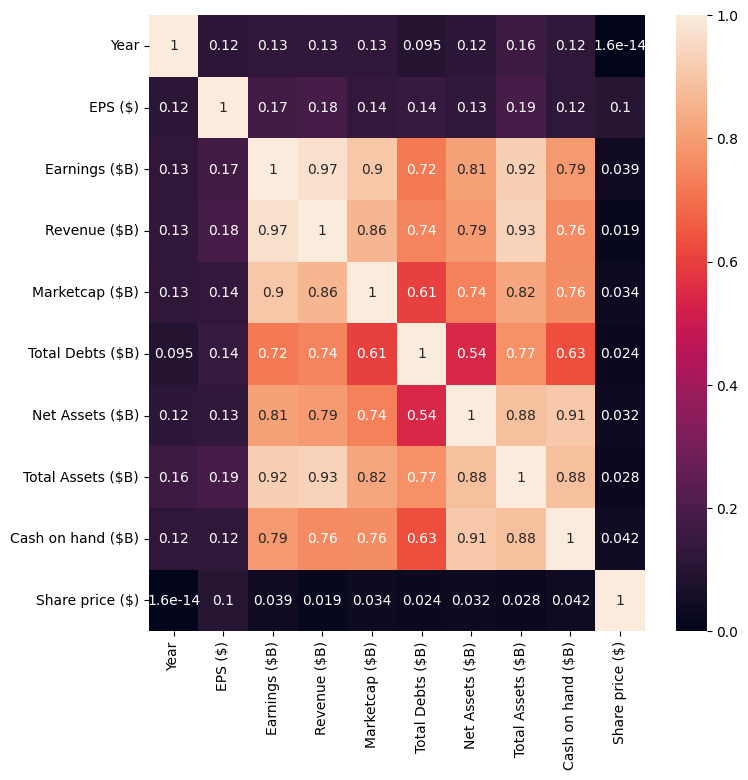

In [6]:
plt.figure(figsize=(8, 8))
sns.heatmap(cleaned_df.corr(), annot=True);

**Nhận xét**

- `Cash on hand` có sự tương quan mạnh (positive) đối với các features: `Earnings`, `Revenue`, `Marketcap`, `Total Debts`, `Net Assets` và `Total Assets`

- Các features còn lại có độ tương quan rất thấp.

- Ta sẽ dùng các features có độ tương quan mạnh để dự đoán target

Visualize bằng `Scatterplot`

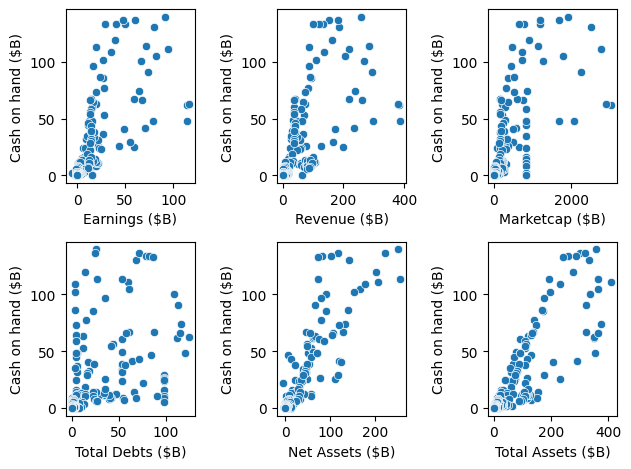

In [7]:
fig, axes = plt.subplots(2, 3)
feature_names = ['Earnings ($B)', 'Revenue ($B)', 'Marketcap ($B)',
       'Total Debts ($B)', 'Net Assets ($B)', 'Total Assets ($B)']

axes = axes.flatten()

for i, ax in enumerate(feature_names):
    sns.scatterplot(data=cleaned_df, x=feature_names[i], y='Cash on hand ($B)', ax= axes[i])
    
plt.tight_layout()

**Nhận xét**

- Giữa các features và target có positive correlation, khi feature tăng lên thì target cũng có xu hướng tăng theo khá rõ rệt.

## Phân phối của các features

Vẽ boxplot để xem phân bố các giá trị trong features và targets

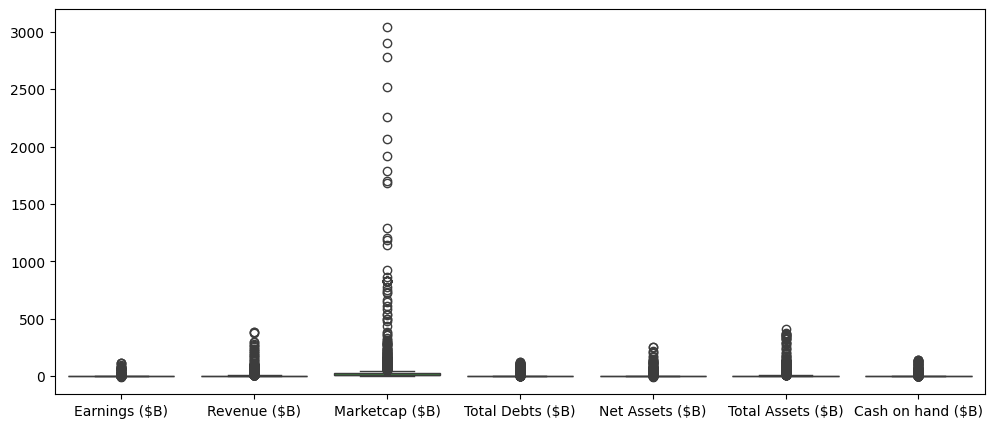

In [8]:
cols = feature_names.copy()
cols.append('Cash on hand ($B)')

plt.figure(figsize=(12, 5))
sns.boxplot(data=cleaned_df[cols]);

**Nhận xét**

- Hầu hết tất cả các cột ta quan tâm đều có rất nhiều `outliers`. Tuy nhiên đây là dữ liệu có thật cho nên ta không thể tự ý xoá bỏ.

- Ta sẽ giữ lại tất cả `outliers`

**Tạo tập X và y**

In [9]:
X = cleaned_df[feature_names].values

y = cleaned_df['Cash on hand ($B)']

print ("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1610, 6)
y shape: (1610,)


## Mô hình hoá 

Do `target` là một cột `Numerical` cho nên ta sẽ dùng các `regression models` để thực hiện mô hình hoá.

Đánh giá performance bằng `5-fold Cross-Validation` 

In [10]:
default_alpha = 0.1
kfold = KFold(n_splits=5, shuffle=True, random_state=21) 


models = {'Linear Regression': LinearRegression(),
          'Lasso': Lasso(default_alpha),
        'Ridge': Ridge(default_alpha)}

for name, model in models.items():

    scores = cross_val_score(model, X, y, cv=kfold)

    print(f'Mean R-squared of {name}: ', scores.mean())


Mean R-squared of Linear Regression:  0.8630163885763901
Mean R-squared of Lasso:  0.8637229062297214
Mean R-squared of Ridge:  0.8630165739953904


**Nhận xét**

- Performance của 3 models không quá chênh lệch. Cao nhất là `Lasso`

# Hyperparamater tuning

Tìm giá trị alpha phù hợp với model nhất (trừ Linear Regression)

In [11]:

param_grid = {"alpha": np.linspace(0.001, 1, 100)}


for name, model in models.items():
    if name == 'Linear Regression':
        continue 
    
    model_cv = GridSearchCV(model, param_grid, cv = kfold)

    model_cv.fit(X, y)
    print("Tuned {} paramaters: {}".format(name, model_cv.best_params_))
    print("Tuned {} score: {}".format(name, model_cv.best_score_))

Tuned Lasso paramaters: {'alpha': 1.0}
Tuned Lasso score: 0.8676362988748562
Tuned Ridge paramaters: {'alpha': 1.0}
Tuned Ridge score: 0.8630182424158146


**Nhận xét**

- Best alpha cho cả 2 model `Ridge` và `Lasso` đều là `1.0`

## Scaling dữ liệu

Bởi vì các regression models mà ta sử dụng (`Linear Regression`, `Lasso` và `Ridge`) thường bị tác động bởi `Scaling`, do đó `Scaling` trước khi training cũng có thể cải thiện hiệu suất của mô hình.

**Lưu ý**: cần chia training set và test set trước khi scaling. Bởi vì khi áp dụng `StandardScaler`, ta muốn giá trị `mean` và `std` chỉ được tính dựa trên training set chứ không phải toàn bộ data hiện có.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(1),
    'Ridge': Ridge(1)
}

for name, model in models.items():

    # Create a pipeline with StandardScaler and Linear Regression
    model = make_pipeline(StandardScaler(), model)

    # Perform cross-validation using R-squared as the scoring metric
    scores = cross_val_score(model, X, y, scoring='r2', cv=kfold)

    # Evaluate performance
    print(f'Mean R-squared of {name}: ', scores.mean())

Mean R-squared of Linear Regression:  0.8630163885763897
Mean R-squared of Lasso:  0.8385836940778914
Mean R-squared of Ridge:  0.8645033854390249


## Kết luận